# Predicting transcription factor-DNA binding from sequence

## Implementation

### Setup

In [ ]:
!pip install bio

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module, Linear, ReLU, Sequential, Conv2d, Conv1d, MaxPool1d, MaxPool2d, BatchNorm1d, BatchNorm2d, Dropout
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import os
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.auto import tqdm, trange
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import OneHotEncoder, normalize
import matplotlib.pyplot as plt
from Bio import SeqIO

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the CPU


In [ ]:
# settings

data_path = "drive/My Drive/CS582/topic1-data/"
batch_size = 100
validation_ratio = 0.2

### Reading Transcription Factors

In [ ]:
def get_tf_list(data_path):
  tf_list = os.listdir(data_path)
  for tf in tf_list:
      if not os.path.isdir(data_path+tf):
          tf_list.remove(tf)
  return tf_list

### Preprocessing & Reading Data

In [ ]:
def one_hot_encoder(sequence):
   encoder = OneHotEncoder(sparse=False, dtype=int, handle_unknown='ignore')
   encoder.fit([['A'], ['T'], ['C'], ['G']])
   onehot_encoded = encoder.transform(sequence)
   return onehot_encoded

In [ ]:
class TFBindingDataset(Dataset):
    def __init__(self, data_path, label_path):
        super(TFBindingDataset, self).__init__()
        self.X = [np.array(list(record.seq.__str__().upper())).reshape(-1, 1) for record in SeqIO.parse(data_path, "fasta")]
        self.X = np.array([one_hot_encoder(data) for data in self.X]).astype('float32')
        shape = self.X.shape
        self.X = torch.as_tensor(self.X.reshape(shape[0], 1, shape[1], shape[2]))
        self.y = pd.read_csv(label_path, sep='\t', header=None).drop(labels=0, axis=1).to_numpy(dtype=float)

    def __getitem__(self, index):
        if torch.is_tensor(index):
           index = index.tolist()
        return self.X[index], self.y[index] 

    def __len__(self):
        return self.X.shape[0]

### Binding Histogram

In [ ]:
def get_binding_values(train_loader, val_loader):
    binding_values = []
    for data in train_loader:
        _, y = data
        binding_values.extend(torch.reshape(y, (-1,)))
    for data in val_loader:
        _, y = data
        binding_values.extend(torch.reshape(y, (-1,)))
    return torch.stack(binding_values)

In [ ]:
def plot_binding_histogram(data_loaders, data_name):
    binding_values = []
    for data_loader in data_loaders:
      for data in data_loader:
          _, y = data
          binding_values.extend(torch.reshape(y, (-1,)))
    binding_values = torch.stack(binding_values)
    plt.figure(figsize=(7,7))
    plt.title(data_name + " Bindings Histogram")
    plt.xlabel("Binding Value")
    plt.ylabel("Count")
    plt.hist(binding_values, bins=40)

### Model

In [ ]:
class BindingPredictionCNN(Module):
    def __init__(self, drop_prob=0.3):
        super().__init__()
        self.conv1 = Conv2d(in_channels=1, out_channels=10, kernel_size=(20, 4), stride=1)
        self.conv2 = Conv1d(in_channels=10, out_channels=20, kernel_size=14, stride=1)
        self.conv3 = Conv1d(in_channels=20, out_channels=30, kernel_size=10, stride=1)
        self.dropout = nn.Dropout(drop_prob)

        self.fc1 = Linear(in_features=30*105, out_features=1500)
        self.fc2 = Linear(in_features=1500, out_features=250)
        self.out = Linear(in_features=250, out_features=1)

    def forward(self, x):
        x = F.relu((self.conv1(x)).squeeze())
        x = F.max_pool1d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

### Training & Testing

In [ ]:
def train(net, train_loader, val_loader, optimizer, criterion, device, epoch_num=100):
    train_log = []
    val_log = []

    for epoch in range(1, epoch_num+1):
        train_loss = []
        net.train()
        for (x, y) in tqdm(train_loader, desc='Training epoch ' + str(epoch), leave=False):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = net(x)
            loss = criterion(outputs.float(), y.float())
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        train_log.append(np.mean(train_loss))
        #print('============ epoch %d =============' %epoch)
        #print('train loss: %.3f' % np.mean(train_loss), flush=True, end='')

        test_loss = []
        net.eval()
        with torch.no_grad():
            for (x, y) in tqdm(val_loader, desc='Validation ', leave=False):
                x, y = x.to(device), y.to(device)
                outputs = net(x)
                loss = criterion(outputs.float(), y.float())
                test_loss.append(loss.item())
        val_log.append(np.mean(test_loss))
        #print('validation loss: %.3f' % np.mean(test_loss), flush=True, end='')
    return train_log, val_log

In [ ]:
def test(net, test_loader, device):
    y_true = []
    y_pred = []
    net.eval()
    with torch.no_grad():
        for (x_input,labels) in tqdm(test_loader, desc='Test ', leave=False):
            x_input, labels = x_input.to(device), labels.to(device)
            outputs = net(x_input)
            y_true.extend(labels.float().detach().cpu().numpy())
            y_pred.extend(outputs.float().detach().cpu().numpy())
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return y_true, y_pred

### Evaluation Plots

In [ ]:
def classification_statistics(y_true_binary, y_pred_binary):
    tn, fp, fn, tp = confusion_matrix(y_true_binary, y_pred_binary).ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * tp / (2 * tp + fp + fn)

    print(confusion_matrix(y_true_binary, y_pred_binary))
    print(classification_report(y_true_binary, y_pred_binary))
    print("=== Statistics ===")
    print("Test Accuracy: %.3f" % accuracy)
    print("Test Sensitivity: %.3f" % sensitivity)
    print("Test Specificity: %.3f" % specificity)
    print("Test F1-Score: %.3f" % f1_score)

In [ ]:
def plot_loss(train_log, val_log, epoch_num, tf):
    plt.figure(figsize=(7,7))
    plt.plot(range(1, epoch_num + 1), train_log, color='C0', label='training')
    plt.plot(range(1, epoch_num + 1), val_log, color='C1', label='validation')
    plt.title('Training and Validation Loss - ' + tf)
    plt.xlabel('Epoch Number')
    plt.ylabel('MSE Loss')
    plt.legend(loc='best')
    plt.show()

In [ ]:
def roc_auc_curve_plot(y_true_binary, y_pred_binary, tf):
  fpr, tpr, _ = roc_curve(y_true_binary, y_pred_binary)
  auc = roc_auc_score(y_true_binary, y_pred_binary)
  plt.figure(figsize=(7,7))
  plt.plot(fpr, tpr, label="auc="+str(auc))
  plt.title('ROC-AUC for Classification Task - ' + tf)
  plt.xlabel('1 - Specificity')
  plt.ylabel('Sensitivity')
  plt.legend(loc='best')
  plt.legend()
  plt.show()

## Evaluation

In [ ]:
tf_list = get_tf_list(data_path)

In [ ]:
# 5 * 5

***************** TCF3 *****************
BindingPredictionCNN(
  (conv1): Conv2d(1, 10, kernel_size=(20, 4), stride=(1, 1))
  (conv2): Conv1d(10, 20, kernel_size=(14,), stride=(1,))
  (conv3): Conv1d(20, 30, kernel_size=(10,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=3150, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=250, bias=True)
  (out): Linear(in_features=250, out_features=1, bias=True)
)


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

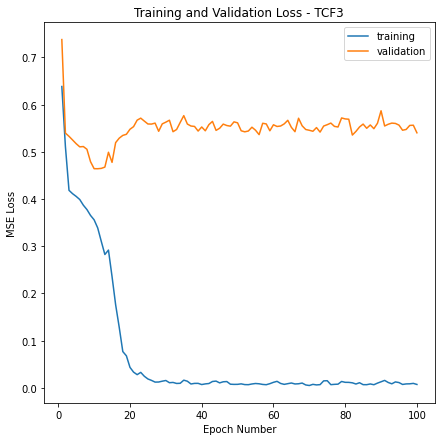

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  0.29015505
0.4315965
[[ 98 109]
 [ 60 133]]
              precision    recall  f1-score   support

           0       0.62      0.47      0.54       207
           1       0.55      0.69      0.61       193

    accuracy                           0.58       400
   macro avg       0.58      0.58      0.57       400
weighted avg       0.59      0.58      0.57       400

=== Statistics ===
Test Accuracy: 0.578
Test Sensitivity: 0.689
Test Specificity: 0.473
Test F1-Score: 0.611


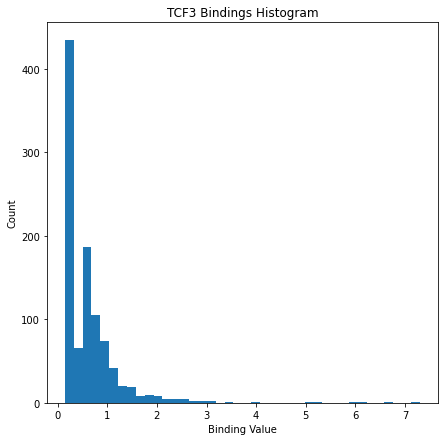

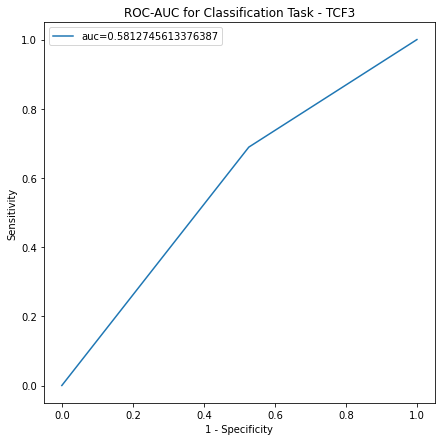

***************** SIN3A *****************
BindingPredictionCNN(
  (conv1): Conv2d(1, 10, kernel_size=(20, 4), stride=(1, 1))
  (conv2): Conv1d(10, 20, kernel_size=(14,), stride=(1,))
  (conv3): Conv1d(20, 30, kernel_size=(10,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=3150, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=250, bias=True)
  (out): Linear(in_features=250, out_features=1, bias=True)
)


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

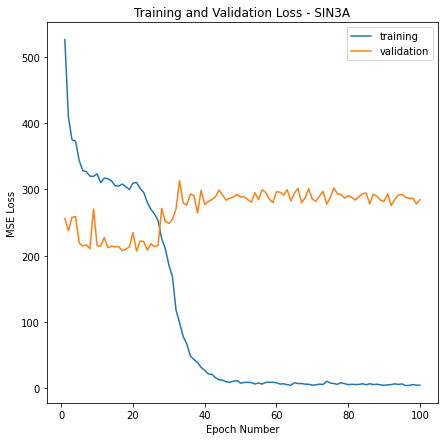

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  298.30145
13.0
[[151  76]
 [ 61 112]]
              precision    recall  f1-score   support

           0       0.71      0.67      0.69       227
           1       0.60      0.65      0.62       173

    accuracy                           0.66       400
   macro avg       0.65      0.66      0.65       400
weighted avg       0.66      0.66      0.66       400

=== Statistics ===
Test Accuracy: 0.657
Test Sensitivity: 0.647
Test Specificity: 0.665
Test F1-Score: 0.620


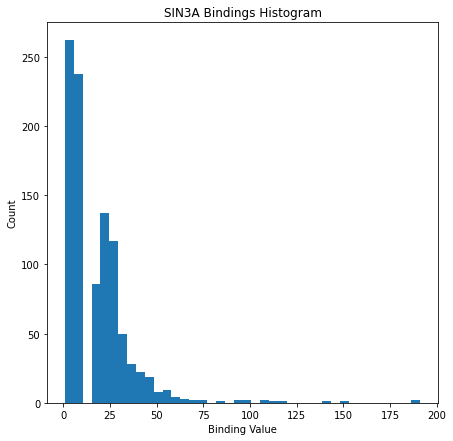

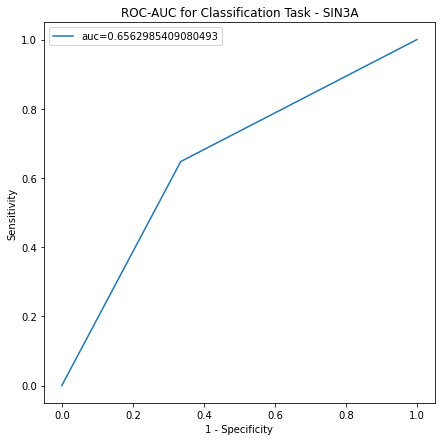

***************** PAX5 *****************
BindingPredictionCNN(
  (conv1): Conv2d(1, 10, kernel_size=(20, 4), stride=(1, 1))
  (conv2): Conv1d(10, 20, kernel_size=(14,), stride=(1,))
  (conv3): Conv1d(20, 30, kernel_size=(10,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=3150, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=250, bias=True)
  (out): Linear(in_features=250, out_features=1, bias=True)
)


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

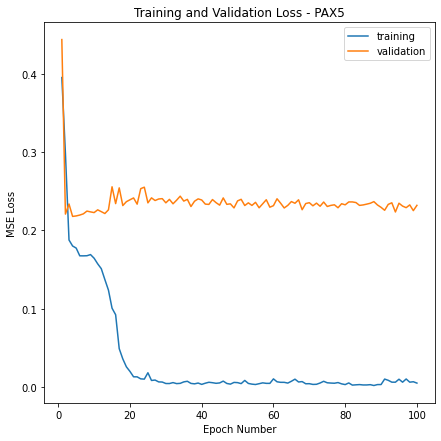

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  0.12417019
0.374741
[[ 59 151]
 [ 51 139]]
              precision    recall  f1-score   support

           0       0.54      0.28      0.37       210
           1       0.48      0.73      0.58       190

    accuracy                           0.49       400
   macro avg       0.51      0.51      0.47       400
weighted avg       0.51      0.49      0.47       400

=== Statistics ===
Test Accuracy: 0.495
Test Sensitivity: 0.732
Test Specificity: 0.281
Test F1-Score: 0.579


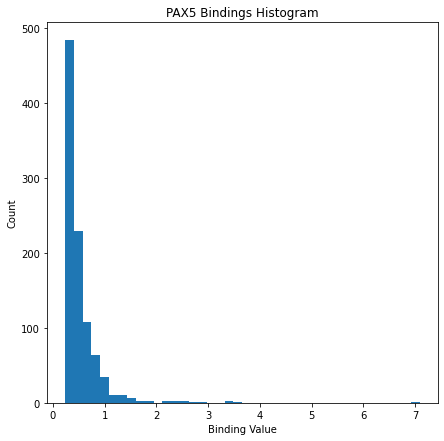

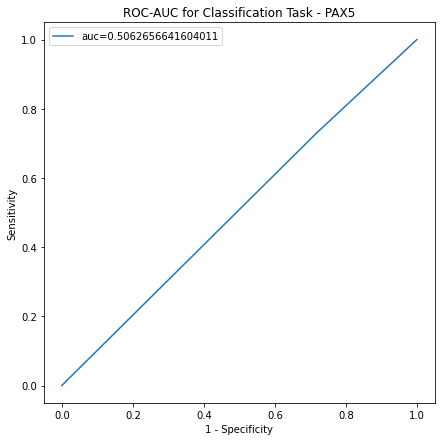

***************** BATF *****************
BindingPredictionCNN(
  (conv1): Conv2d(1, 10, kernel_size=(20, 4), stride=(1, 1))
  (conv2): Conv1d(10, 20, kernel_size=(14,), stride=(1,))
  (conv3): Conv1d(20, 30, kernel_size=(10,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=3150, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=250, bias=True)
  (out): Linear(in_features=250, out_features=1, bias=True)
)


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

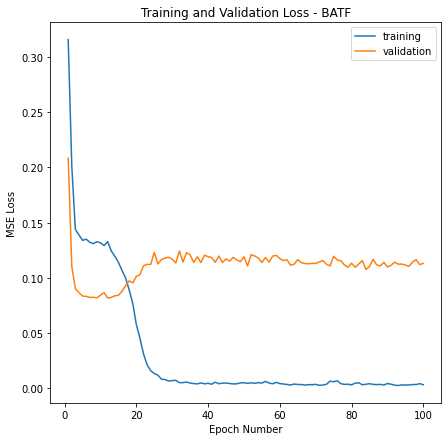

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  0.21369928
0.386426
[[ 99  95]
 [103 103]]
              precision    recall  f1-score   support

           0       0.49      0.51      0.50       194
           1       0.52      0.50      0.51       206

    accuracy                           0.51       400
   macro avg       0.51      0.51      0.50       400
weighted avg       0.51      0.51      0.51       400

=== Statistics ===
Test Accuracy: 0.505
Test Sensitivity: 0.500
Test Specificity: 0.510
Test F1-Score: 0.510


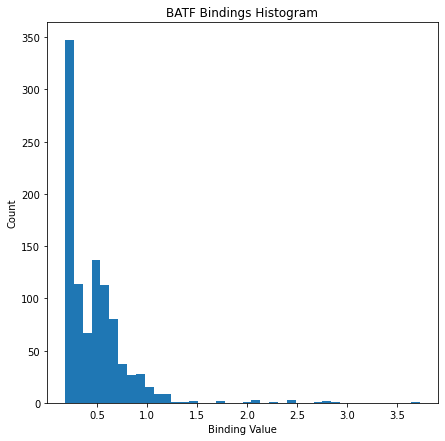

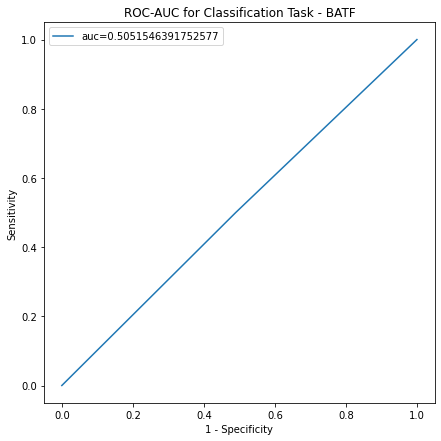

***************** BCL3 *****************
BindingPredictionCNN(
  (conv1): Conv2d(1, 10, kernel_size=(20, 4), stride=(1, 1))
  (conv2): Conv1d(10, 20, kernel_size=(14,), stride=(1,))
  (conv3): Conv1d(20, 30, kernel_size=(10,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=3150, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=250, bias=True)
  (out): Linear(in_features=250, out_features=1, bias=True)
)


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

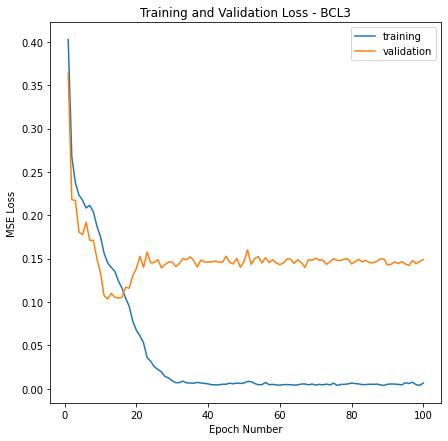

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  0.16352127
0.49322449999999995
[[163  51]
 [ 70 116]]
              precision    recall  f1-score   support

           0       0.70      0.76      0.73       214
           1       0.69      0.62      0.66       186

    accuracy                           0.70       400
   macro avg       0.70      0.69      0.69       400
weighted avg       0.70      0.70      0.70       400

=== Statistics ===
Test Accuracy: 0.698
Test Sensitivity: 0.624
Test Specificity: 0.762
Test F1-Score: 0.657


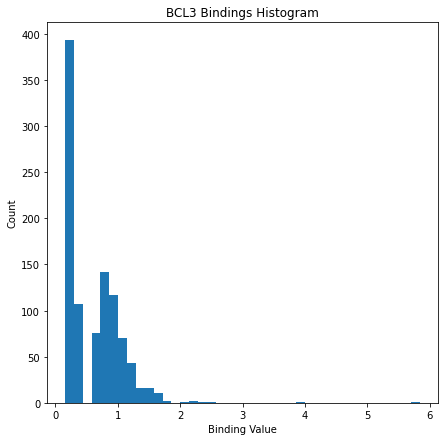

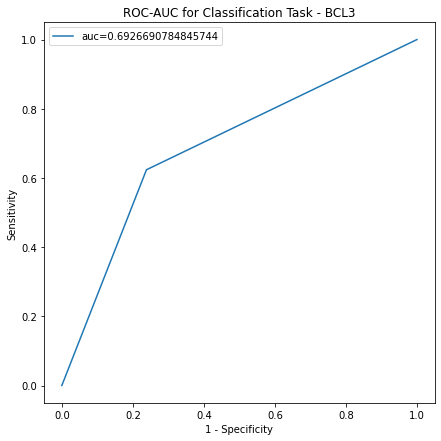

***************** RUNX3 *****************
BindingPredictionCNN(
  (conv1): Conv2d(1, 10, kernel_size=(20, 4), stride=(1, 1))
  (conv2): Conv1d(10, 20, kernel_size=(14,), stride=(1,))
  (conv3): Conv1d(20, 30, kernel_size=(10,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=3150, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=250, bias=True)
  (out): Linear(in_features=250, out_features=1, bias=True)
)


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

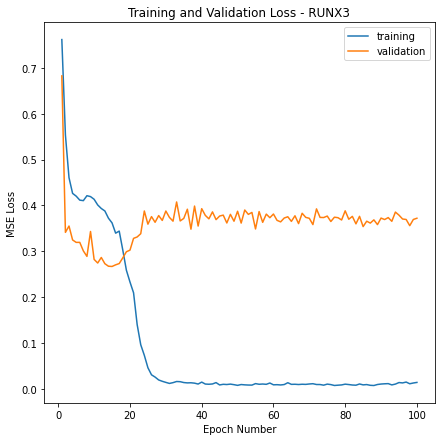

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  0.5409485
0.661621
[[142  70]
 [ 98  90]]
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       212
           1       0.56      0.48      0.52       188

    accuracy                           0.58       400
   macro avg       0.58      0.57      0.57       400
weighted avg       0.58      0.58      0.58       400

=== Statistics ===
Test Accuracy: 0.580
Test Sensitivity: 0.479
Test Specificity: 0.670
Test F1-Score: 0.517


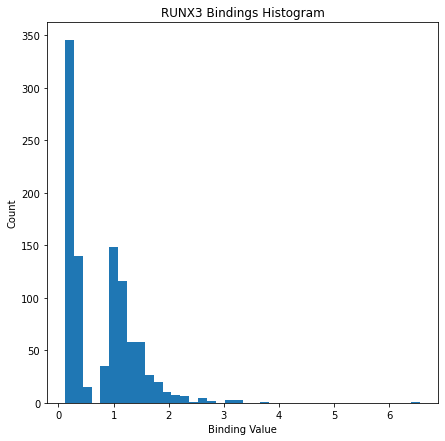

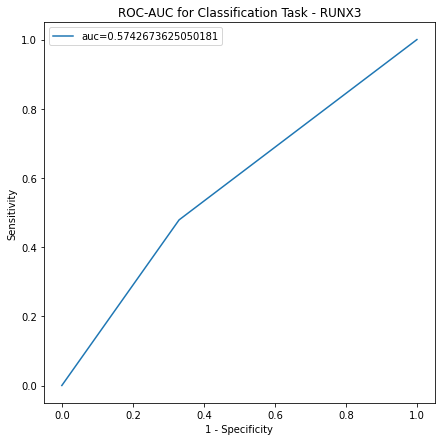

***************** MEF2A *****************
BindingPredictionCNN(
  (conv1): Conv2d(1, 10, kernel_size=(20, 4), stride=(1, 1))
  (conv2): Conv1d(10, 20, kernel_size=(14,), stride=(1,))
  (conv3): Conv1d(20, 30, kernel_size=(10,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=3150, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=250, bias=True)
  (out): Linear(in_features=250, out_features=1, bias=True)
)


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

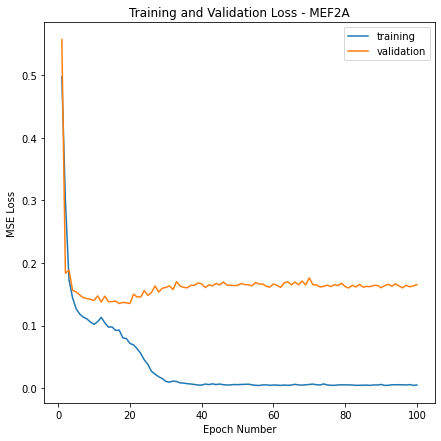

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  0.1452205
0.5808835
[[104  62]
 [ 58 176]]
              precision    recall  f1-score   support

           0       0.64      0.63      0.63       166
           1       0.74      0.75      0.75       234

    accuracy                           0.70       400
   macro avg       0.69      0.69      0.69       400
weighted avg       0.70      0.70      0.70       400

=== Statistics ===
Test Accuracy: 0.700
Test Sensitivity: 0.752
Test Specificity: 0.627
Test F1-Score: 0.746


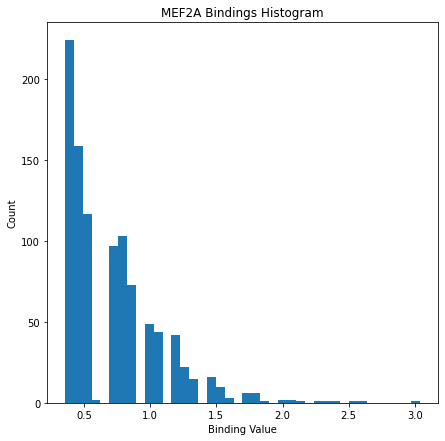

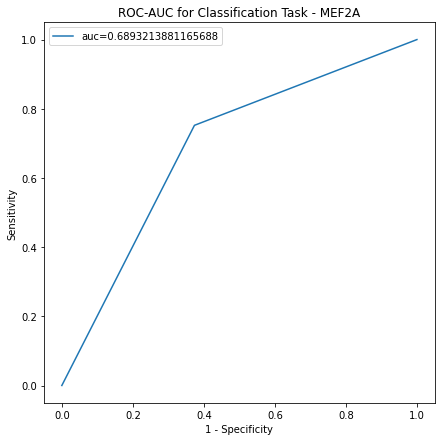

***************** ZEB1 *****************
BindingPredictionCNN(
  (conv1): Conv2d(1, 10, kernel_size=(20, 4), stride=(1, 1))
  (conv2): Conv1d(10, 20, kernel_size=(14,), stride=(1,))
  (conv3): Conv1d(20, 30, kernel_size=(10,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=3150, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=250, bias=True)
  (out): Linear(in_features=250, out_features=1, bias=True)
)


Training epoch 1:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

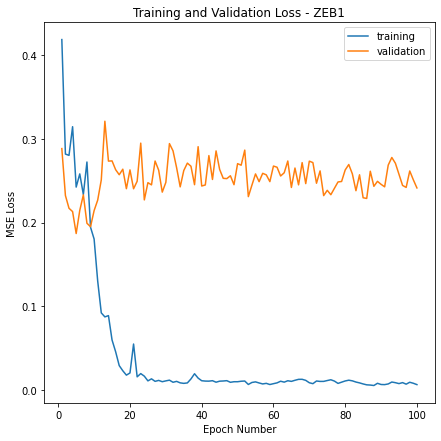

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  0.1938601
0.5982275
[[ 85 121]
 [ 68 126]]
              precision    recall  f1-score   support

           0       0.56      0.41      0.47       206
           1       0.51      0.65      0.57       194

    accuracy                           0.53       400
   macro avg       0.53      0.53      0.52       400
weighted avg       0.53      0.53      0.52       400

=== Statistics ===
Test Accuracy: 0.527
Test Sensitivity: 0.649
Test Specificity: 0.413
Test F1-Score: 0.571


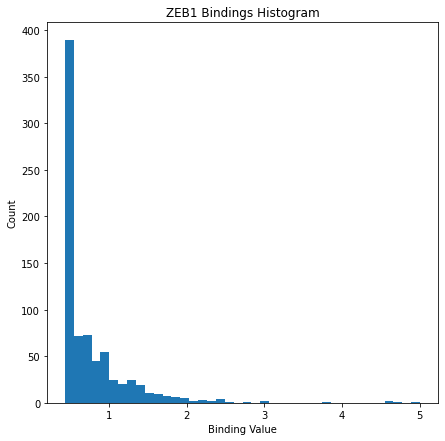

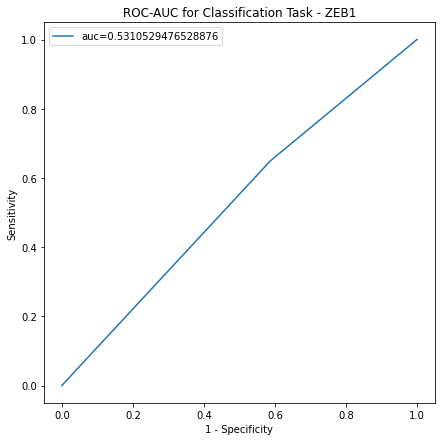

***************** MXI1 *****************
BindingPredictionCNN(
  (conv1): Conv2d(1, 10, kernel_size=(20, 4), stride=(1, 1))
  (conv2): Conv1d(10, 20, kernel_size=(14,), stride=(1,))
  (conv3): Conv1d(20, 30, kernel_size=(10,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=3150, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=250, bias=True)
  (out): Linear(in_features=250, out_features=1, bias=True)
)


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

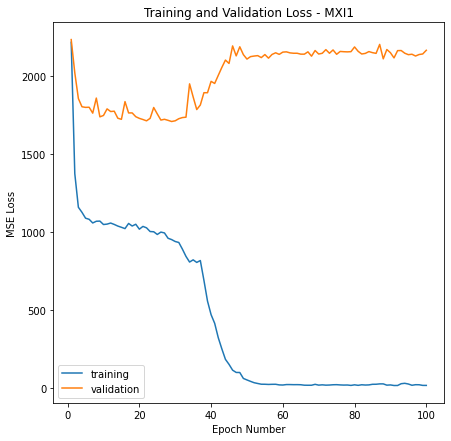

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  1658.3271
34.0
[[119 102]
 [ 75 104]]
              precision    recall  f1-score   support

           0       0.61      0.54      0.57       221
           1       0.50      0.58      0.54       179

    accuracy                           0.56       400
   macro avg       0.56      0.56      0.56       400
weighted avg       0.56      0.56      0.56       400

=== Statistics ===
Test Accuracy: 0.557
Test Sensitivity: 0.581
Test Specificity: 0.538
Test F1-Score: 0.540


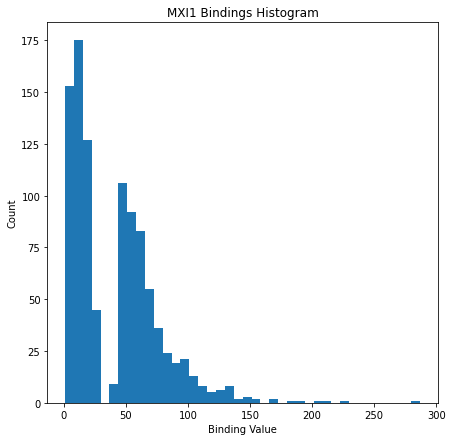

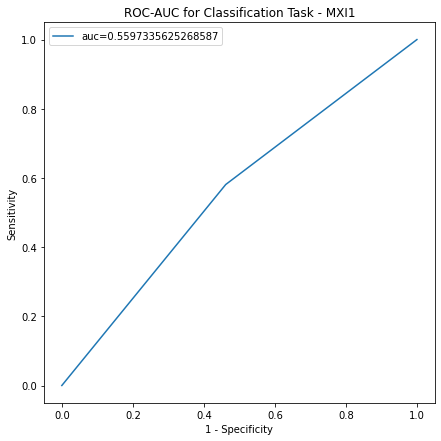

***************** NFYB *****************
BindingPredictionCNN(
  (conv1): Conv2d(1, 10, kernel_size=(20, 4), stride=(1, 1))
  (conv2): Conv1d(10, 20, kernel_size=(14,), stride=(1,))
  (conv3): Conv1d(20, 30, kernel_size=(10,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=3150, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=250, bias=True)
  (out): Linear(in_features=250, out_features=1, bias=True)
)


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

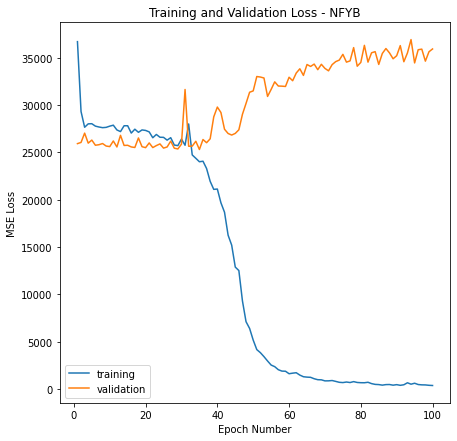

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  39435.145
51.5
[[166  93]
 [ 36 105]]
              precision    recall  f1-score   support

           0       0.82      0.64      0.72       259
           1       0.53      0.74      0.62       141

    accuracy                           0.68       400
   macro avg       0.68      0.69      0.67       400
weighted avg       0.72      0.68      0.68       400

=== Statistics ===
Test Accuracy: 0.677
Test Sensitivity: 0.745
Test Specificity: 0.641
Test F1-Score: 0.619


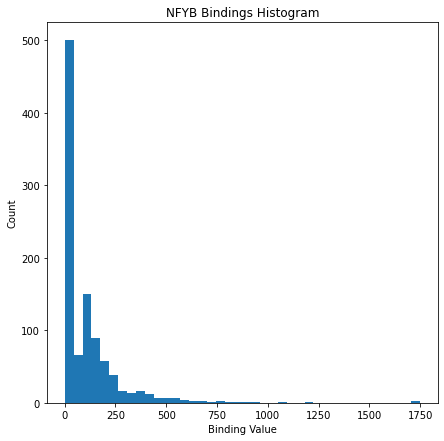

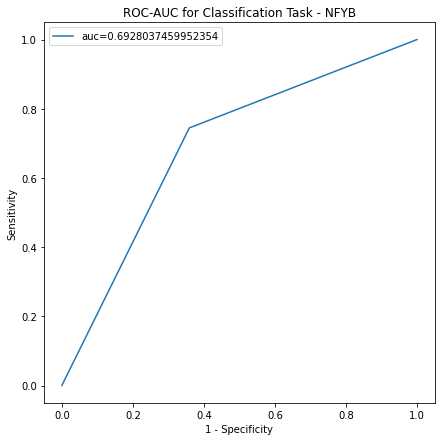

***************** IKZF1 *****************
BindingPredictionCNN(
  (conv1): Conv2d(1, 10, kernel_size=(20, 4), stride=(1, 1))
  (conv2): Conv1d(10, 20, kernel_size=(14,), stride=(1,))
  (conv3): Conv1d(20, 30, kernel_size=(10,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=3150, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=250, bias=True)
  (out): Linear(in_features=250, out_features=1, bias=True)
)


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

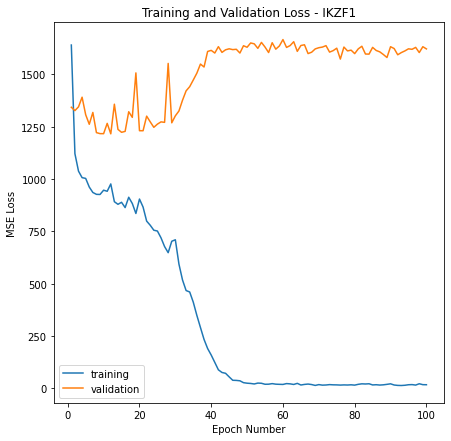

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  1189.3378
27.0
[[134 110]
 [ 53 103]]
              precision    recall  f1-score   support

           0       0.72      0.55      0.62       244
           1       0.48      0.66      0.56       156

    accuracy                           0.59       400
   macro avg       0.60      0.60      0.59       400
weighted avg       0.63      0.59      0.60       400

=== Statistics ===
Test Accuracy: 0.593
Test Sensitivity: 0.660
Test Specificity: 0.549
Test F1-Score: 0.558


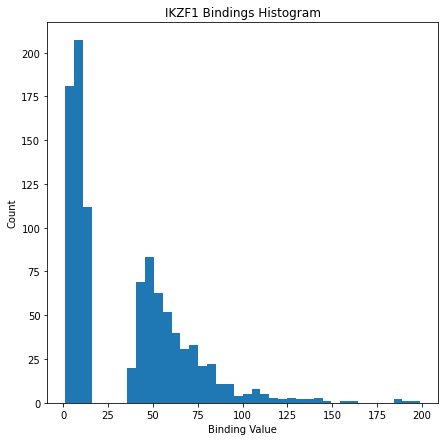

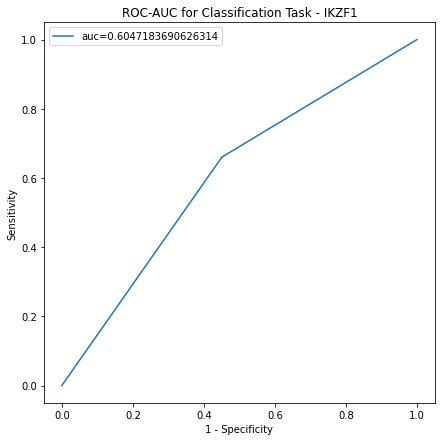

***************** YY1 *****************
BindingPredictionCNN(
  (conv1): Conv2d(1, 10, kernel_size=(20, 4), stride=(1, 1))
  (conv2): Conv1d(10, 20, kernel_size=(14,), stride=(1,))
  (conv3): Conv1d(20, 30, kernel_size=(10,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=3150, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=250, bias=True)
  (out): Linear(in_features=250, out_features=1, bias=True)
)


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

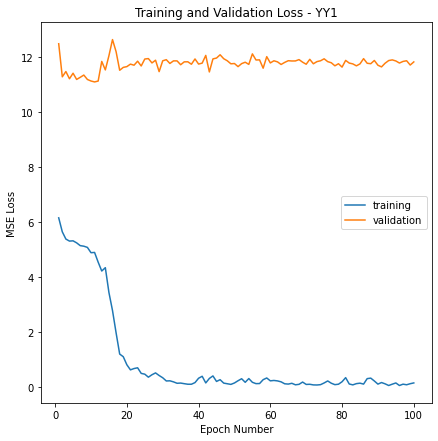

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  4.493402
0.7506285
[[ 83 162]
 [ 30 125]]
              precision    recall  f1-score   support

           0       0.73      0.34      0.46       245
           1       0.44      0.81      0.57       155

    accuracy                           0.52       400
   macro avg       0.59      0.57      0.51       400
weighted avg       0.62      0.52      0.50       400

=== Statistics ===
Test Accuracy: 0.520
Test Sensitivity: 0.806
Test Specificity: 0.339
Test F1-Score: 0.566


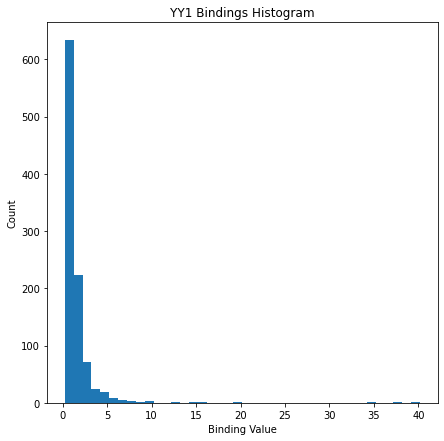

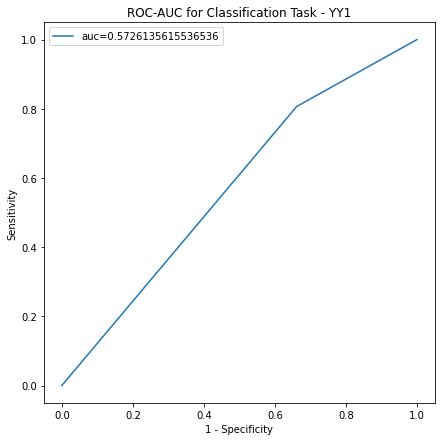

***************** SPI1 *****************
BindingPredictionCNN(
  (conv1): Conv2d(1, 10, kernel_size=(20, 4), stride=(1, 1))
  (conv2): Conv1d(10, 20, kernel_size=(14,), stride=(1,))
  (conv3): Conv1d(20, 30, kernel_size=(10,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=3150, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=250, bias=True)
  (out): Linear(in_features=250, out_features=1, bias=True)
)


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

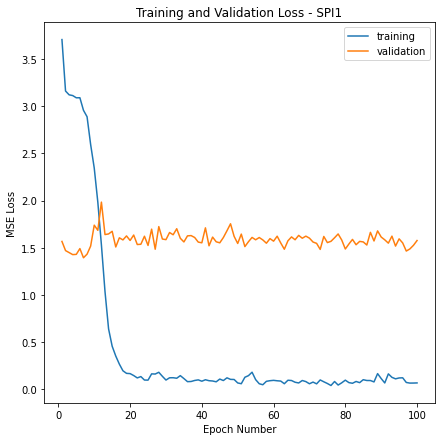

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  1.7700565
0.8671785000000001
[[144  67]
 [111  78]]
              precision    recall  f1-score   support

           0       0.56      0.68      0.62       211
           1       0.54      0.41      0.47       189

    accuracy                           0.56       400
   macro avg       0.55      0.55      0.54       400
weighted avg       0.55      0.56      0.55       400

=== Statistics ===
Test Accuracy: 0.555
Test Sensitivity: 0.413
Test Specificity: 0.682
Test F1-Score: 0.467


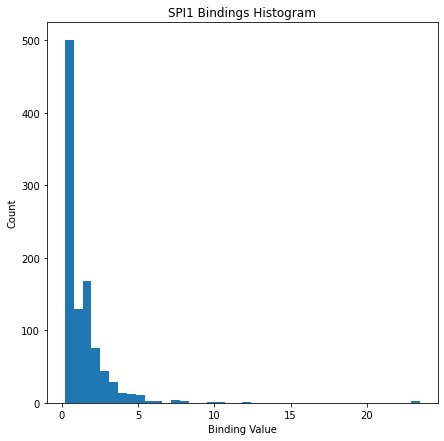

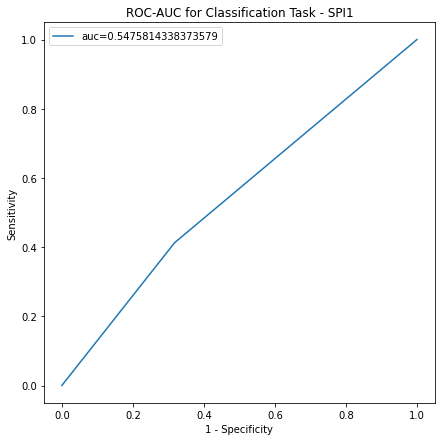

***************** RELA *****************
BindingPredictionCNN(
  (conv1): Conv2d(1, 10, kernel_size=(20, 4), stride=(1, 1))
  (conv2): Conv1d(10, 20, kernel_size=(14,), stride=(1,))
  (conv3): Conv1d(20, 30, kernel_size=(10,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=3150, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=250, bias=True)
  (out): Linear(in_features=250, out_features=1, bias=True)
)


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

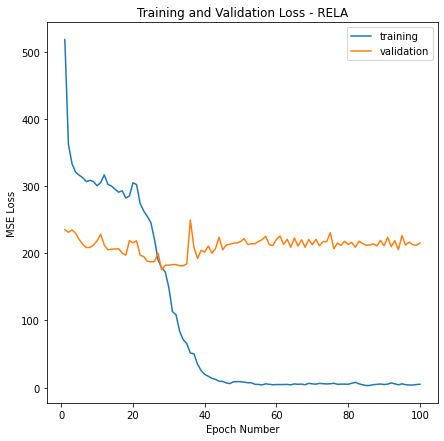

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  346.5997
13.899999999999999
[[160  86]
 [ 34 120]]
              precision    recall  f1-score   support

           0       0.82      0.65      0.73       246
           1       0.58      0.78      0.67       154

    accuracy                           0.70       400
   macro avg       0.70      0.71      0.70       400
weighted avg       0.73      0.70      0.70       400

=== Statistics ===
Test Accuracy: 0.700
Test Sensitivity: 0.779
Test Specificity: 0.650
Test F1-Score: 0.667


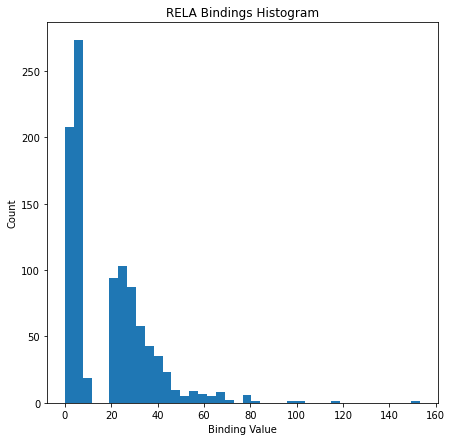

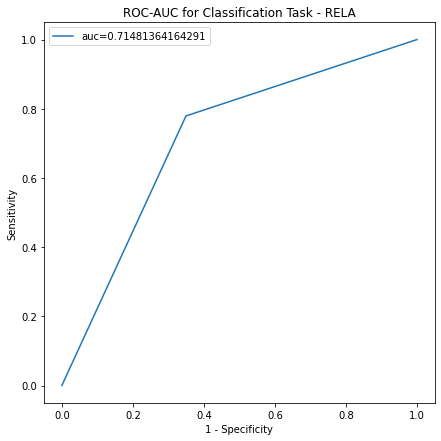

***************** NFATC1 *****************
BindingPredictionCNN(
  (conv1): Conv2d(1, 10, kernel_size=(20, 4), stride=(1, 1))
  (conv2): Conv1d(10, 20, kernel_size=(14,), stride=(1,))
  (conv3): Conv1d(20, 30, kernel_size=(10,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=3150, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=250, bias=True)
  (out): Linear(in_features=250, out_features=1, bias=True)
)


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

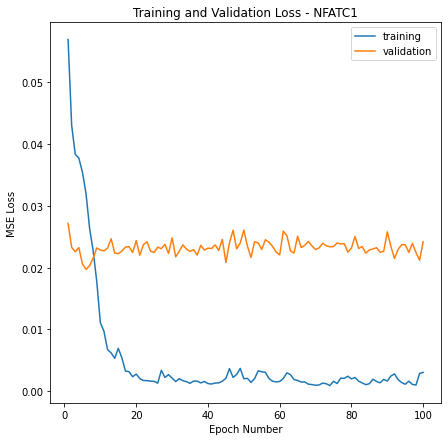

Test :   0%|          | 0/4 [00:00<?, ?it/s]

Test MSE:  0.065152735
0.23549150000000002
[[ 96 103]
 [ 85 116]]
              precision    recall  f1-score   support

           0       0.53      0.48      0.51       199
           1       0.53      0.58      0.55       201

    accuracy                           0.53       400
   macro avg       0.53      0.53      0.53       400
weighted avg       0.53      0.53      0.53       400

=== Statistics ===
Test Accuracy: 0.530
Test Sensitivity: 0.577
Test Specificity: 0.482
Test F1-Score: 0.552


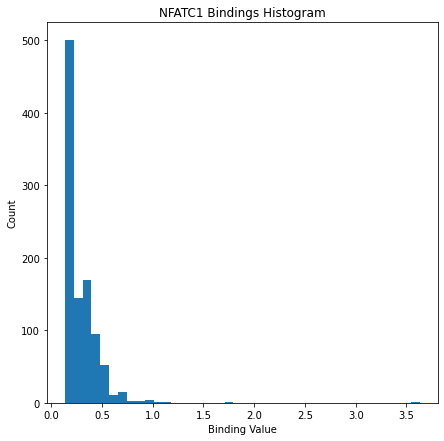

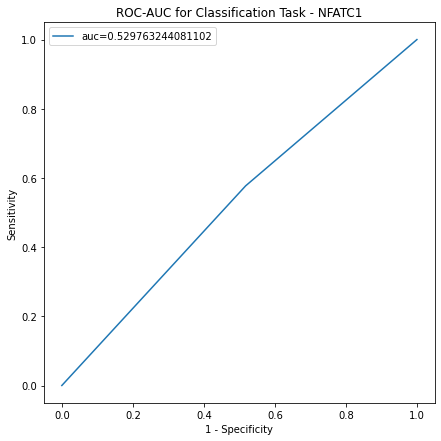

***************** USF1 *****************
BindingPredictionCNN(
  (conv1): Conv2d(1, 10, kernel_size=(20, 4), stride=(1, 1))
  (conv2): Conv1d(10, 20, kernel_size=(14,), stride=(1,))
  (conv3): Conv1d(20, 30, kernel_size=(10,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=3150, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=250, bias=True)
  (out): Linear(in_features=250, out_features=1, bias=True)
)


Training epoch 1:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/7 [00:00<?, ?it/s]

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
for tf in tf_list:
  print("***************** " + tf + " *****************")
  train_data_path = data_path + tf + '/' + tf + '-train-sequence.fa'
  test_data_path = data_path + tf + '/' + tf + "-test-sequence.fa"
  train_label_path = data_path + tf + '/' + tf + "-train.bed"
  test_label_path = data_path + tf + '/' + tf + "-test.bed"

  train_set = TFBindingDataset(train_data_path, train_label_path) 
  test_set = TFBindingDataset(test_data_path, test_label_path)  
  train_set, val_set = random_split(train_set, [int(len(train_set)) - int(len(train_set)*validation_ratio), int(len(train_set)*validation_ratio)])    

  train_loader = DataLoader(dataset=train_set,
                            batch_size=batch_size,
                            shuffle=True)
  val_loader = DataLoader(dataset=val_set,
                            batch_size=batch_size,
                            shuffle=True)
  test_loader = DataLoader(dataset=test_set,
                          batch_size=batch_size,
                          shuffle=True)
  
  model = BindingPredictionCNN()
  model = model.to(device)
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  print(model)

  train_log, val_log = train(model, train_loader, val_loader, optimizer, criterion, device)
  plot_loss(train_log, val_log, 100, tf)
  y_true, y_pred = test(model, test_loader, device)
  print("Test MSE: ", mean_squared_error(y_true, y_pred))

  plot_binding_histogram([train_loader, val_loader], tf)
  binding_values = get_binding_values(train_loader, val_loader)
  binding_threshold = np.median(binding_values)
  print(binding_threshold)

  y_pred_binary = (y_pred > binding_threshold) * 1
  y_true_binary = (y_true > binding_threshold) * 1
  classification_statistics(y_true_binary, y_pred_binary)
  roc_auc_curve_plot(y_true_binary,  y_pred_binary, tf)

In [ ]:
tf_list

['TCF3',
 'SIN3A',
 'PAX5',
 'BATF',
 'BCL3',
 'RUNX3',
 'MEF2A',
 'ZEB1',
 'MXI1',
 'NFYB',
 'IKZF1',
 'YY1',
 'SPI1',
 'RELA',
 'NFATC1',
 'USF1',
 'ELF1',
 'MAX',
 'BHLHE40',
 'EBF1',
 'ZNF143',
 'USF2',
 'NFIC',
 'TCF12',
 'REST',
 'EGR1']

In [ ]:
tf = tf_list[4]

In [ ]:
train_data_path = data_path + tf + '/' + tf + '-train-sequence.fa'
test_data_path = data_path + tf + '/' + tf + "-test-sequence.fa"
train_label_path = data_path + tf + '/' + tf + "-train.bed"
test_label_path = data_path + tf + '/' + tf + "-test.bed"

In [ ]:
train_set = TFBindingDataset(train_data_path, train_label_path) 
test_set = TFBindingDataset(test_data_path, test_label_path)  
train_set, val_set = random_split(train_set, [int(len(train_set)) - int(len(train_set)*validation_ratio), int(len(train_set)*validation_ratio)])    

train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(dataset=val_set,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_set,
                        batch_size=batch_size,
                         shuffle=True)

In [ ]:
for data in train_loader:
    X, y = data 
    print(X.shape)
    print(y.shape)
    break

torch.Size([100, 1, 501, 4])
torch.Size([100, 1])


In [ ]:
model = BindingPredictionCNN()
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

BindingPredictionCNN(
  (conv1): Conv2d(1, 10, kernel_size=(20, 4), stride=(1, 1))
  (conv2): Conv1d(10, 20, kernel_size=(14,), stride=(1,))
  (conv3): Conv1d(20, 30, kernel_size=(10,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=3150, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=250, bias=True)
  (out): Linear(in_features=250, out_features=1, bias=True)
)


In [ ]:
train_log, val_log = train(model, train_loader, val_loader, optimizer, criterion, device)

Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 1 =============
train loss: 0.326

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.517

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 2 =============
train loss: 0.187

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.403

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 3 =============
train loss: 0.152

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.394

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 4 =============
train loss: 0.140

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.381

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 5 =============
train loss: 0.135

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.390

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 6 =============
train loss: 0.139

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.367

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 7 =============
train loss: 0.136

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.371

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 8 =============
train loss: 0.134

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.383

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 9 =============
train loss: 0.132

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.370

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 10 =============
train loss: 0.132

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.381

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 11 =============
train loss: 0.136

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.383

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 12 =============
train loss: 0.129

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.368

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 13 =============
train loss: 0.127

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.364

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 14 =============
train loss: 0.128

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.368

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 15 =============
train loss: 0.129

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.368

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 16 =============
train loss: 0.124

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.371

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 17 =============
train loss: 0.117

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.388

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 18 =============
train loss: 0.113

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.371

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 19 =============
train loss: 0.106

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.369

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 20 =============
train loss: 0.093

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.380

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 21 =============
train loss: 0.089

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.382

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 22 =============
train loss: 0.068

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.388

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 23 =============
train loss: 0.055

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.386

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 24 =============
train loss: 0.036

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.399

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 25 =============
train loss: 0.026

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.395

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 26 =============
train loss: 0.018

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.399

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 27 =============
train loss: 0.014

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.397

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 28 =============
train loss: 0.009

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.393

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 29 =============
train loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.412

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 30 =============
train loss: 0.009

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.397

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 31 =============
train loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.394

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 32 =============
train loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.387

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 33 =============
train loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.393

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 34 =============
train loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.406

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 35 =============
train loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.387

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 36 =============
train loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.405

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 37 =============
train loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.388

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 38 =============
train loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.386

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 39 =============
train loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.394

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 40 =============
train loss: 0.007

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.385

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 41 =============
train loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.406

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 42 =============
train loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.390

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 43 =============
train loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.404

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 44 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.395

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 45 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.389

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 46 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.391

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 47 =============
train loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.410

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 48 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.406

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 49 =============
train loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.405

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 50 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.390

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 51 =============
train loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.406

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 52 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.395

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 53 =============
train loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.393

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 54 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.413

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 55 =============
train loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.391

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 56 =============
train loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.406

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 57 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.405

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 58 =============
train loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.413

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 59 =============
train loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.409

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 60 =============
train loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.408

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 61 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.407

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 62 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.385

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 63 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.402

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 64 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.411

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 65 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.390

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 66 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.384

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 67 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.412

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 68 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.405

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 69 =============
train loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.390

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 70 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.390

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 71 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.405

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 72 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.386

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 73 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.389

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 74 =============
train loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.406

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 75 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.403

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 76 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.390

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 77 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.386

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 78 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.391

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 79 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.388

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 80 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.384

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 81 =============
train loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.407

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 82 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.394

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 83 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.404

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 84 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.400

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 85 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.400

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 86 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.401

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 87 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.390

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 88 =============
train loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.403

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 89 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.386

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 90 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.398

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 91 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.389

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 92 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.391

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 93 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.387

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 94 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.402

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 95 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.392

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 96 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.392

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 97 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.406

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 98 =============
train loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.395

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 99 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.411

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 100 =============
train loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.395

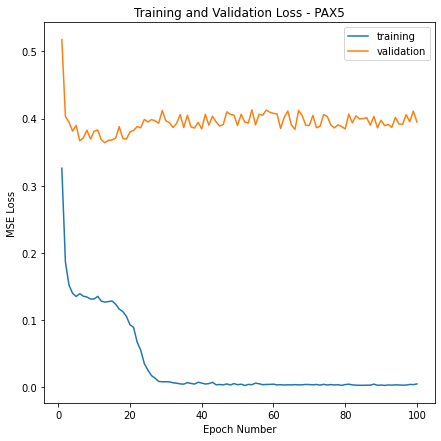

In [ ]:
plot_loss(train_log, val_log, 100, tf)

In [ ]:
y_true, y_pred = test(model, test_loader, device)

Test :   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
print("Test MSE: ", mean_squared_error(y_true, y_pred))

Test MSE:  0.14124961


### Classification

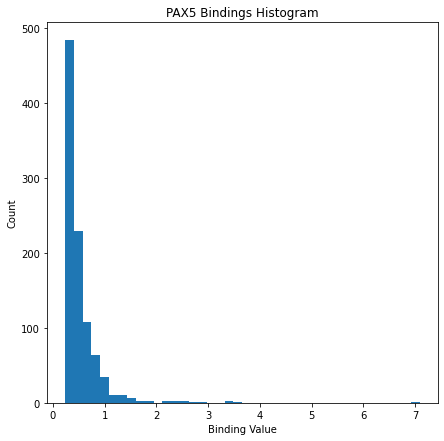

In [ ]:
plot_binding_histogram([train_loader, val_loader], tf)

In [ ]:
binding_values = get_binding_values(train_loader, val_loader)

In [ ]:
binding_threshold = np.median(binding_values)

In [ ]:
binding_threshold

0.374741

In [ ]:
y_pred_binary = (y_pred > binding_threshold) * 1
y_true_binary = (y_true > binding_threshold) * 1

In [ ]:
classification_statistics(y_true_binary, y_pred_binary)

[[110 100]
 [ 85 105]]
              precision    recall  f1-score   support

           0       0.56      0.52      0.54       210
           1       0.51      0.55      0.53       190

    accuracy                           0.54       400
   macro avg       0.54      0.54      0.54       400
weighted avg       0.54      0.54      0.54       400

=== Statistics ===
Test Accuracy: 0.537
Test Sensitivity: 0.553
Test Specificity: 0.524
Test F1-Score: 0.532


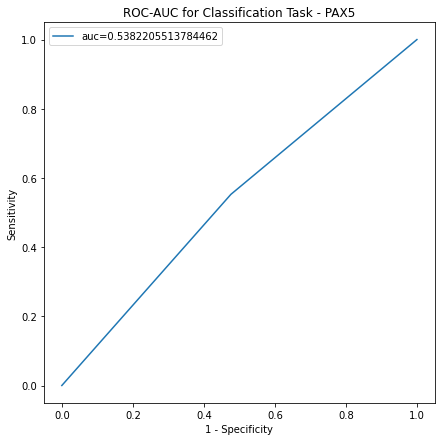

In [ ]:
roc_auc_curve_plot(y_true_binary,  y_pred_binary, tf)